In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import MonoLogitTrans
import LinearModel
import sklearn
from sklearn.linear_model import LogisticRegressionCV
import time

**此Demo用sklearn中乳腺癌数据演示MonoLogitTrans模块对单变量进行数据转化，以及用LinearModel模块对转化之后的数据建立二分类模型**

主要包括以下几个模块：

1. 获取模拟数据
2. 利用MonoLogitTrans对单变量进行转化
3. 建模对比
4. 对比迭代初始值设置
5. 对比Q0和Q1的选择

### 获取模拟数据

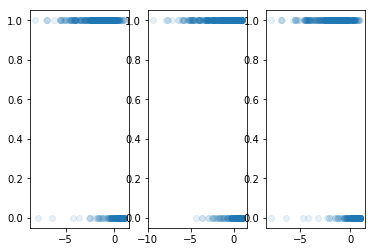

In [2]:
importlib.reload(LinearModel)
x1,x2,x3,x1_test,x2_test,x3_test,y,y_test = MonoLogitTrans.get_data()

plt.subplot(1,3,1)
plt.plot(x1,y,'o',alpha=0.1)
plt.subplot(1,3,2)
plt.plot(x2,y,'o',alpha=0.1)
plt.subplot(1,3,3)
plt.plot(x3,y,'o',alpha=0.1)
plt.show()

### 利用MonoLogitTrans对单变量进行转化

In [3]:
importlib.reload(MonoLogitTrans)
MonoLogitTrans1 = MonoLogitTrans.MonoLogitTrans(method='strict')
MonoLogitTrans2 = MonoLogitTrans.MonoLogitTrans(method='wide')
MonoLogitTrans3 = MonoLogitTrans.MonoLogitTrans(method='wide',num_hidden=30)
time1 = time.time()
MonoLogitTrans1.fit(x1,y)
MonoLogitTrans2.fit(x2,y)
MonoLogitTrans3.fit(x3,y)
time2 = time.time()
print(time2-time1)

x1_trans = MonoLogitTrans1.transform(x1_test)
x2_trans = MonoLogitTrans2.transform(x2_test)
x3_trans = MonoLogitTrans3.transform(x3_test)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
5.709745168685913


C:\Users\BBD\Desktop\标准化代码开发\同步文件夹\Code\Modeling\MonoLogitTrans.py:329: RuntimeWarning: invalid value encountered in less
  while (((Loss[-2]-Loss[-1])/(np.abs(Loss[-2])+1e-10)>.001) or ((Loss[-2]-Loss[-1])<0) or step_<30) & (step_<=max_iter):


**存储和加载参数**

In [4]:
#save parameters
MonoLogitTrans1.save_parameter('MonoLogitTrans1.txt')
MonoLogitTrans2.save_parameter('MonoLogitTrans2.txt')
MonoLogitTrans3.save_parameter('MonoLogitTrans3.txt')
#load parameters
MonoLogitTrans1_ = MonoLogitTrans.MonoLogitTrans()
MonoLogitTrans2_ = MonoLogitTrans.MonoLogitTrans()
MonoLogitTrans3_ = MonoLogitTrans.MonoLogitTrans()
MonoLogitTrans1_.load_parameter('MonoLogitTrans1.txt')
MonoLogitTrans2_.load_parameter('MonoLogitTrans2.txt')
MonoLogitTrans3_.load_parameter('MonoLogitTrans3.txt')
x1_trans = MonoLogitTrans1_.transform(x1_test)
x2_trans = MonoLogitTrans2_.transform(x2_test)
x3_trans = MonoLogitTrans3_.transform(x3_test)

#### 对其中的连续变量，观察损失函数变化曲线，确定收敛

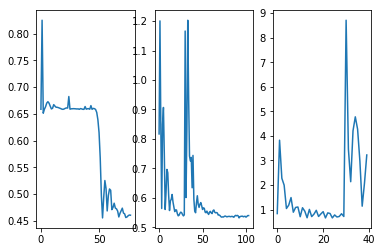

In [5]:
plt.subplot(1,3,1)
plt.plot(MonoLogitTrans1.Loss)
plt.subplot(1,3,2)
plt.plot(MonoLogitTrans2.Loss)
plt.subplot(1,3,3)
plt.plot(MonoLogitTrans3.Loss)
plt.show()

#### 原数据(横坐标)和转化数据(纵坐标)对比

若选择了method='wide'，如后两个变量，则

通过调整lambda_monotonous参数的大小，可以控制单调限制的程度。lambda_monotonous越大，转化越被限制为单调变化

若选择了method='strict'，如第一个变量，则转换函数一定是单调函数

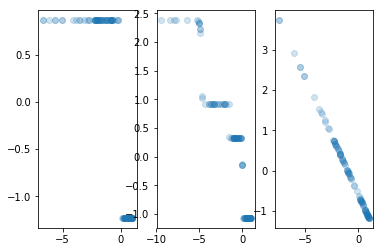

In [6]:
plt.subplot(1,3,1)
plt.plot(x1_test,x1_trans,'o',alpha=0.2)
plt.subplot(1,3,2)
plt.plot(x2_test,x2_trans,'o',alpha=0.2)
plt.subplot(1,3,3)
plt.plot(x3_test,x3_trans,'o',alpha=0.2)
plt.show()

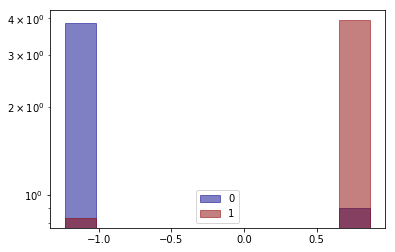

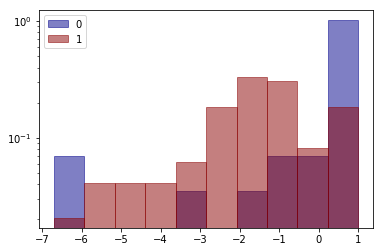

In [7]:
MonoLogitTrans.PlotComparableHistogram(variable_=pd.Series(x1_trans),lable_=pd.Series(y_test))
MonoLogitTrans.PlotComparableHistogram(variable_=pd.Series(x1_test),lable_=pd.Series(y_test))

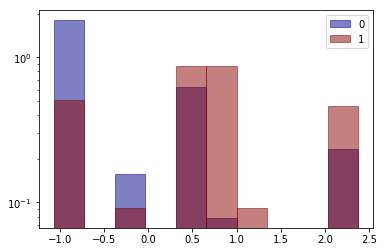

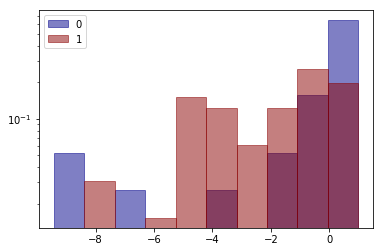

In [8]:
MonoLogitTrans.PlotComparableHistogram(variable_=pd.Series(x2_trans),lable_=pd.Series(y_test))
MonoLogitTrans.PlotComparableHistogram(variable_=pd.Series(x2_test),lable_=pd.Series(y_test))

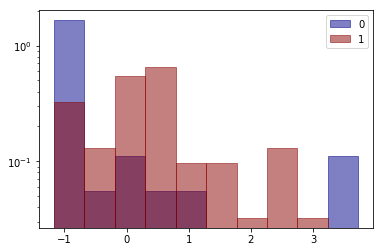

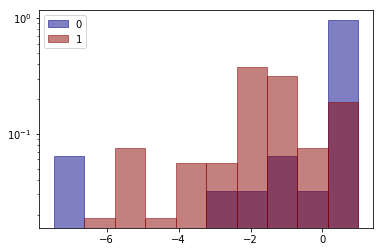

In [9]:
MonoLogitTrans.PlotComparableHistogram(variable_=pd.Series(x3_trans),lable_=pd.Series(y_test))
MonoLogitTrans.PlotComparableHistogram(variable_=pd.Series(x3_test),lable_=pd.Series(y_test))

#### 得到原数据测试集和转化数据测试集

In [10]:
x1_test = np.reshape(x1_test,(len(x1_test),1))
x2_test = np.reshape(x2_test,(len(x2_test),1))
x3_test = np.reshape(x3_test,(len(x3_test),1))
x1_trans = np.reshape(x1_trans,(len(x1_trans),1))
x2_trans = np.reshape(x2_trans,(len(x2_trans),1))
x3_trans = np.reshape(x3_trans,(len(x3_trans),1))

X_origin = np.concatenate((x1_test,x2_test,x3_test),axis=1)
X_trans = np.concatenate((x1_trans,x2_trans,x3_trans),axis=1)

### 建模对比

由于转化之后，单变量与Y正相关，所以转化数据利用LinearModel模块中的PosLassoClassifierCV模型进行回归，原数据用sklearn包的LogisticRegressionCV回归建模

In [11]:
model1 = LinearModel.PosLassoClassifierCV(beta_mean=True,start_point='OLS')
model1.fit(X_trans,y_test)
model2 = LogisticRegressionCV(cv=5)
model2.fit(X_origin,y_test)

CV loop No.0 for lambda=0.01
2019-08/09/19 18:18:17	40	3.3995786
CV loop No.1 for lambda=0.01
2019-08/09/19 18:18:18	40	3.3967185
2019-08/09/19 18:18:18	60	3.4028552
2019-08/09/19 18:18:18	80	3.3984587
CV loop No.0 for lambda=0.001
2019-08/09/19 18:18:19	40	3.3913655
CV loop No.1 for lambda=0.001
2019-08/09/19 18:18:19	40	3.3616278
2019-08/09/19 18:18:19	60	3.3862865
2019-08/09/19 18:18:19	80	3.3705938
CV loop No.0 for lambda=0.0001
2019-08/09/19 18:18:20	40	3.3845565
CV loop No.1 for lambda=0.0001
2019-08/09/19 18:18:20	40	3.372146
2019-08/09/19 18:18:21	60	3.377436
2019-08/09/19 18:18:21	80	3.398234
2019-08/09/19 18:18:21	100	3.3740573
CV loop No.0 for lambda=1e-05
2019-08/09/19 18:18:21	40	3.3765843
2019-08/09/19 18:18:21	60	3.4008632
2019-08/09/19 18:18:21	80	3.364159
2019-08/09/19 18:18:21	100	3.4340858
CV loop No.1 for lambda=1e-05
2019-08/09/19 18:18:22	40	3.365442
2019-08/09/19 18:18:22	60	3.3585987
CV loop No.0 for lambda=1e-06
2019-08/09/19 18:18:23	40	3.3778265
2019-08/09/19

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

#### 模型系数

In [12]:
model1.coef_

array([1.50855744, 1.02819061, 0.        ])

In [13]:
model2.coef_

array([[-1.4170879 , -0.29881972,  0.61332106]])

#### 预测

In [14]:
y_hat_trans = model1.predict_proba(X_trans)
y_hat_origin = model2.predict_proba(X_origin)[:,1]

In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
roc_auc_score(y_test,y_hat_trans)

0.9045474045474046

In [17]:
roc_auc_score(y_test,y_hat_origin)

0.8601458601458601

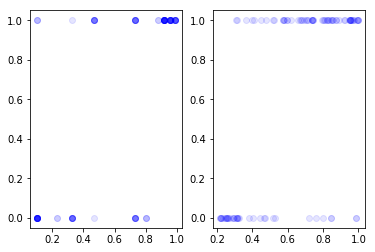

In [18]:
plt.subplot(1,2,1)
plt.plot(y_hat_trans,y_test,'bo',alpha=0.1)
plt.subplot(1,2,2)
plt.plot(y_hat_origin,y_test,'bo',alpha=0.1)
plt.show()

ks_value is 0.6984 at pop = 0.44


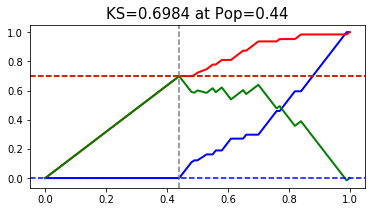

,tile,cumsum_good,cumsum_bad,ks
0,0.00,0.000000,0.000000,0.000000
1,0.02,0.000000,0.031746,0.031746
2,0.03,0.000000,0.047619,0.047619
3,0.04,0.000000,0.063492,0.063492
4,0.05,0.000000,0.079365,0.079365
5,0.06,0.000000,0.095238,0.095238
6,0.07,0.000000,0.111111,0.111111
7,0.08,0.000000,0.126984,0.126984
8,0.09,0.000000,0.142857,0.142857
9,0.10,0.000000,0.158730,0.158730


In [32]:
MonoLogitTrans.PlotKS(y_hat_trans,y_test)

ks_value is 0.668 at pop = 0.61


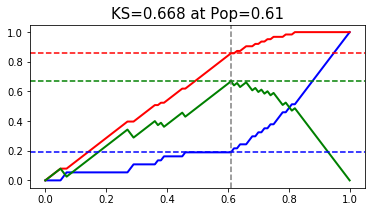

,tile,cumsum_good,cumsum_bad,ks
0,0.00,0.000000,0.000000,0.000000
1,0.02,0.000000,0.031746,0.031746
2,0.03,0.000000,0.047619,0.047619
3,0.04,0.000000,0.063492,0.063492
4,0.05,0.000000,0.079365,0.079365
5,0.06,0.027027,0.079365,0.052338
6,0.07,0.054054,0.079365,0.025311
7,0.08,0.054054,0.095238,0.041184
8,0.09,0.054054,0.111111,0.057057
9,0.10,0.054054,0.126984,0.072930


In [33]:
MonoLogitTrans.PlotKS(y_hat_origin,y_test)

## 对比迭代初始值设置

In [21]:
model1 = LinearModel.LassoClassifierCV(beta_mean=True,start_point='ridge')
model1.fit(X_origin,y_test)
model2 = LinearModel.LassoClassifierCV(beta_mean=True,start_point=None)
model2.fit(X_origin,y_test)
y_hat_1 = model1.predict_proba(X_origin)
y_hat_2 = model2.predict_proba(X_origin)

CV loop No.0 for lambda=0.1
2019-08/09/19 18:18:26	40	4.8997073
CV loop No.1 for lambda=0.1
2019-08/09/19 18:18:27	40	4.7791486
2019-08/09/19 18:18:27	60	4.8096604
2019-08/09/19 18:18:27	80	4.7806597
CV loop No.0 for lambda=0.01
2019-08/09/19 18:18:27	40	4.6894207
2019-08/09/19 18:18:27	60	4.665232
2019-08/09/19 18:18:27	80	4.747594
2019-08/09/19 18:18:27	100	4.6562057
CV loop No.1 for lambda=0.01
2019-08/09/19 18:18:28	40	4.6737676
2019-08/09/19 18:18:28	60	4.777191
2019-08/09/19 18:18:28	80	4.670516
2019-08/09/19 18:18:28	100	4.662051
CV loop No.0 for lambda=0.001
2019-08/09/19 18:18:29	40	4.65017
CV loop No.1 for lambda=0.001
2019-08/09/19 18:18:29	40	4.7163787
2019-08/09/19 18:18:29	60	4.625625
2019-08/09/19 18:18:29	80	4.6292677
CV loop No.0 for lambda=0.0001
2019-08/09/19 18:18:30	40	4.6405945
CV loop No.1 for lambda=0.0001
2019-08/09/19 18:18:30	40	4.665439
2019-08/09/19 18:18:30	60	4.6622458
2019-08/09/19 18:18:30	80	4.66782
2019-08/09/19 18:18:30	100	4.626461
CV loop No.0 for 

#### Ridge作为模型系数的迭代初始值

In [22]:
roc_auc_score(y_test,y_hat_1)

0.8635778635778636

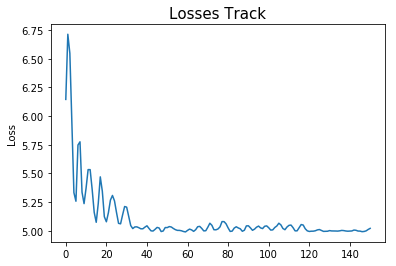

In [23]:
model1.plotLoss()

#### 随机正态作为模型系数的迭代初始值

In [24]:
roc_auc_score(y_test,y_hat_2)

0.8575718575718576

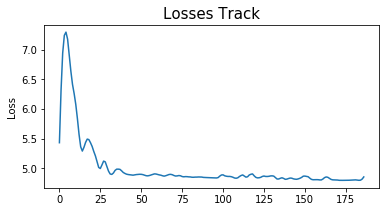

In [25]:
model2.plotLoss()

## 对比Q0和Q1的选择

In [44]:
model1 = LinearModel.LassoClassifierCV(beta_mean=True,Q0=0.95,Q1=0.95,max_iter=300)
model1.fit(X_origin,y_test)
model2 = LinearModel.LassoClassifierCV(beta_mean=True,Q0=1,Q1=1)
model2.fit(X_origin,y_test)
y_hat_1 = model1.predict_proba(X_origin)
y_hat_2 = model2.predict_proba(X_origin)

CV loop No.0 for lambda=0.1
2019-08/09/19 18:20:37	40	5.478268
2019-08/09/19 18:20:37	60	5.3010693
2019-08/09/19 18:20:37	80	5.638361
2019-08/09/19 18:20:37	100	5.2381816
2019-08/09/19 18:20:37	120	5.3738856
2019-08/09/19 18:20:38	140	5.479625
CV loop No.1 for lambda=0.1
2019-08/09/19 18:20:38	40	5.497798
2019-08/09/19 18:20:38	60	5.4023514
2019-08/09/19 18:20:38	80	4.9658213
2019-08/09/19 18:20:38	100	5.104805
2019-08/09/19 18:20:38	120	5.1438007
2019-08/09/19 18:20:38	140	5.121686
2019-08/09/19 18:20:38	160	5.427606
CV loop No.0 for lambda=0.01
2019-08/09/19 18:20:39	40	5.330625
2019-08/09/19 18:20:39	60	5.0719295
2019-08/09/19 18:20:39	80	5.1090336
2019-08/09/19 18:20:39	100	5.086024
2019-08/09/19 18:20:39	120	4.9216614
2019-08/09/19 18:20:39	140	5.440086
CV loop No.1 for lambda=0.01
2019-08/09/19 18:20:40	40	5.9233212
2019-08/09/19 18:20:40	60	4.9509315
2019-08/09/19 18:20:40	80	5.00849
2019-08/09/19 18:20:40	100	5.603754
CV loop No.0 for lambda=0.001
2019-08/09/19 18:20:40	40	5.51

#### 稳健建模

In [45]:
roc_auc_score(y_test,y_hat_1)

0.8712998712998713

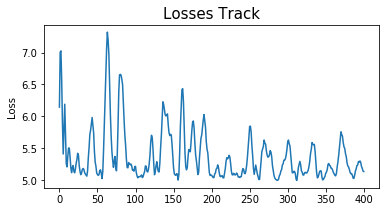

In [46]:
model1.plotLoss()

#### 原始版本建模

In [47]:
roc_auc_score(y_test,y_hat_2)

0.8537108537108536

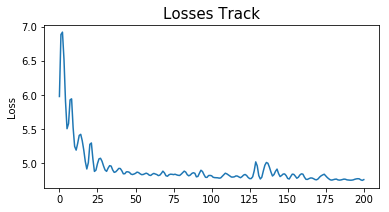

In [48]:
model2.plotLoss()